In [1]:
import random
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from utils.graph import draw_learning_curve
from utils.data_loader import create_dataset

2024-04-08 02:59:34.819839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 02:59:34.819861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 02:59:34.820453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 02:59:34.824224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 02:59:35.333148: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-08 02:59:36.120033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 02:59:36.134816: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 02:59:36.134961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


2024-04-08 02:59:36.147914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 02:59:36.148131: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 02:59:36.148302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
SEED = 0
IMG_DIM = 299
BATCH_SIZE = 16
FOLD = 5

In [5]:
DATA_CSV = f'data/datasplit_fold{FOLD}.csv'

In [6]:
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [7]:
df = pd.read_csv(DATA_CSV)

In [8]:
train_ds = create_dataset(df=df, batch_size=BATCH_SIZE, mode='train')
val_ds = create_dataset(df=df, batch_size=BATCH_SIZE, mode='val')

In [9]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet'
)

In [10]:
base_model.trainable = False

In [11]:
inputs = tf.keras.Input(shape=(IMG_DIM, IMG_DIM, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(16, name='logits')(x)
outputs = layers.Activation('softmax', name='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

In [13]:
initial_history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10


2024-04-08 02:59:59.433049: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/380 [..............................] - ETA: 25:30 - loss: 0.6188 - accuracy: 0.0000e+00

2024-04-08 03:00:01.814352: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f91049189a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 03:00:01.814601: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-08 03:00:01.819504: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712520001.889410   31047 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


380/380 [==============================] - 39s 92ms/step - loss: 1.1042 - accuracy: 0.3451 - val_loss: 0.7002 - val_accuracy: 0.5122
Epoch 2/10
380/380 [==============================] - 34s 88ms/step - loss: 0.6660 - accuracy: 0.5064 - val_loss: 0.5606 - val_accuracy: 0.5715
Epoch 3/10
380/380 [==============================] - 34s 89ms/step - loss: 0.5280 - accuracy: 0.5787 - val_loss: 0.4035 - val_accuracy: 0.6042
Epoch 4/10
380/380 [==============================] - 34s 89ms/step - loss: 0.4011 - accuracy: 0.6408 - val_loss: 0.4024 - val_accuracy: 0.6353
Epoch 5/10
380/380 [==============================] - 34s 89ms/step - loss: 0.3766 - accuracy: 0.6704 - val_loss: 0.3516 - val_accuracy: 0.6753
Epoch 6/10
380/380 [==============================] - 34s 89ms/step - loss: 0.3538 - accuracy: 0.6760 - val_loss: 0.4917 - val_accuracy: 0.6509
Epoch 7/10
380/380 [==============================] - 34s 88ms/step - loss: 0.2937 - accuracy: 0.7172 - val_loss: 0.4509 - val_accuracy: 0.6197
Epo

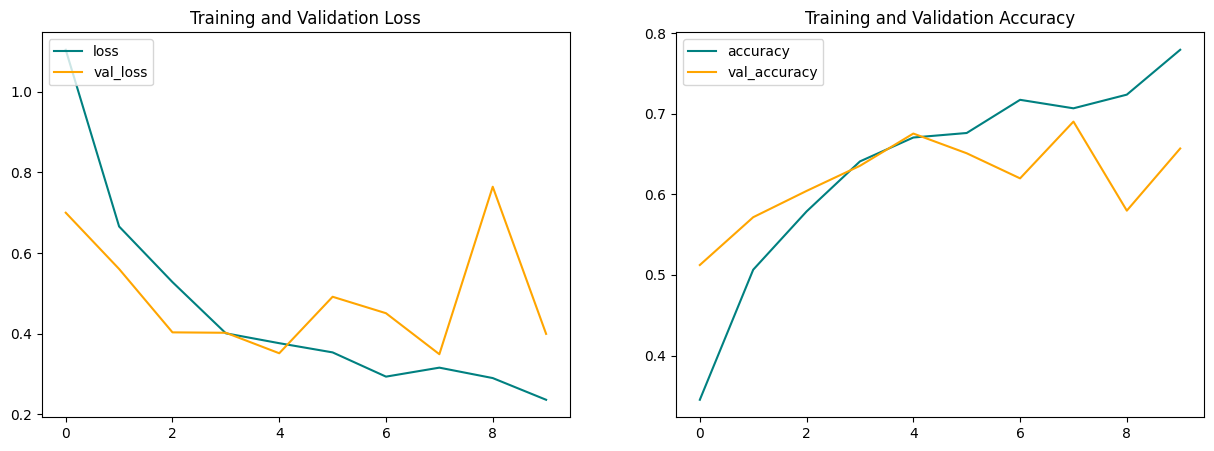

In [14]:
draw_learning_curve(initial_history)

In [15]:
base_model.trainable = True

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
)

Epoch 1/20


2024-04-08 03:06:00.077373: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


380/380 [==============================] - 138s 302ms/step - loss: 0.2129 - accuracy: 0.6092 - val_loss: 0.1858 - val_accuracy: 0.6657
Epoch 2/20
380/380 [==============================] - 107s 282ms/step - loss: 0.0901 - accuracy: 0.7861 - val_loss: 0.2155 - val_accuracy: 0.6516
Epoch 3/20
380/380 [==============================] - 107s 282ms/step - loss: 0.0389 - accuracy: 0.8859 - val_loss: 0.1234 - val_accuracy: 0.7413
Epoch 4/20
380/380 [==============================] - 107s 282ms/step - loss: 0.0286 - accuracy: 0.9142 - val_loss: 0.0786 - val_accuracy: 0.8288
Epoch 5/20
380/380 [==============================] - 108s 283ms/step - loss: 0.0028 - accuracy: 0.9858 - val_loss: 0.0646 - val_accuracy: 0.8577
Epoch 6/20
380/380 [==============================] - 116s 305ms/step - loss: 6.7532e-04 - accuracy: 0.9969 - val_loss: 0.0614 - val_accuracy: 0.8940
Epoch 7/20
380/380 [==============================] - 118s 311ms/step - loss: 5.9390e-05 - accuracy: 1.0000 - val_loss: 0.0649 - va

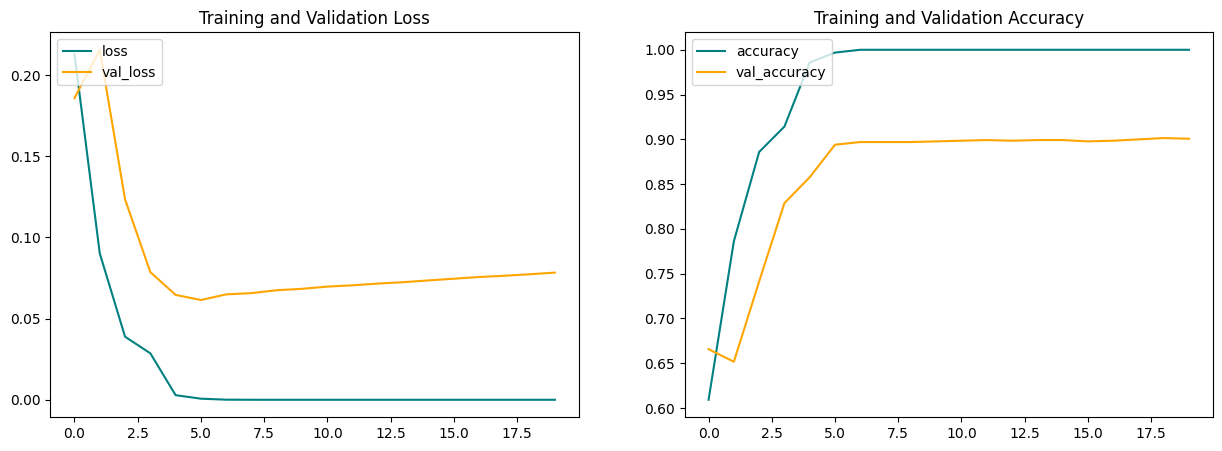

In [18]:
draw_learning_curve(history)

In [19]:
model.save(f'models/fold_{FOLD}.h5')

/home/bit/Workpaces/pace-up/openmax-body-img/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
